# Black Friday Contest
### https://datahack.analyticsvidhya.com/contest/black-friday/

## Problem Statement

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [90]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
description=pd.read_csv('description.csv',sep='\t',index_col='Variable')
print(description)

                                                                   Definition
Variable                                                                     
User_ID                                                               User ID
Product_ID                                                         Product ID
Gender                                                            Sex of User
Age                                                               Age in bins
Occupation                                                Occupation (Masked)
City_Category                                    Category of the City (A,B,C)
Stay_In_Current_City_Years               Number of years stay in current city
Marital_Status                                                 Marital Status
Product_Category_1                                  Product Category (Masked)
Product_Category_2          Product may belongs to other category also (Ma...
Product_Category_3          Product may belongs to other categor

In [91]:
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
User_ID                       233599 non-null int64
Product_ID              

## Analysis
Now we analyze all the columns one by one, beginning with the User Id column

1.071 %


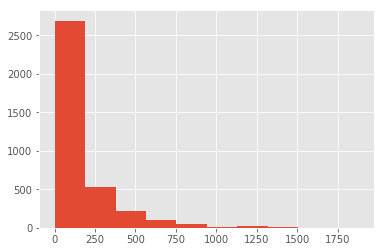

In [92]:
print('%.3f %%'%(len(train['User_ID'].unique())/len(train)*100))
train["Product_ID"].value_counts().hist();

Only one percent of users have unique Ids making it possibly very influential as a feature. We should however [one-hot encode](https://visualstudiomagazine.com/articles/2013/07/01/neural-network-data-normalization-and-encoding.aspx) it as there is no meaningful user ordering possible.

In [93]:
train_user_ids=set(train['User_ID'])
test_user_ids=set(test['User_ID'])
test_user_ids-train_user_ids

set()

Thankfully there will be no new users in the test part of the dataset and we may fit our labelencoder on the train part without any nasty surprises on the test part. It is essential that we do this check to avoid haphazard changes later on. See [this](https://stats.stackexchange.com/questions/325499/handle-categorical-values-in-test-that-arent-in-train) for why it is so nasty.

In [96]:
from sklearn.preprocessing import OneHotEncoder
user_id_encoder=OneHotEncoder()
user_id_encoder.categories_c = list(train_user_ids)
encoded_ids=user_id_encoder.fit_transform(train['User_ID'].values.reshape(1,-1))

AxisError: axis -1 is out of bounds for array of dimension 0

In [27]:
print('%0.3f %%'%(len(train['Product_ID'].unique())/len(train)*100))
train_product_ids=set(train['Product_ID'])
test_product_ids=set(test['Product_ID'])
print(len(test_product_ids-train_product_ids))

0.660 %
46


Hmm.. This is quite concerning There are products in the test set that are not present in the test set.

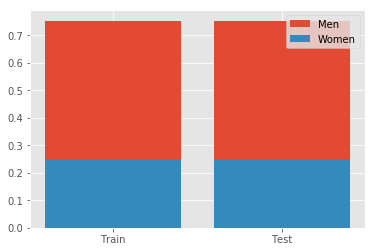

In [81]:
M1,F1=train['Gender'].value_counts()/len(train)
M2,F2=test['Gender'].value_counts()/len(test)
index=np.arange(2)
men=plt.bar(index,[M1,M2],tick_label=['Train','Test'])
women=plt.bar(index,[F1,F2],tick_label=['Train','Test'])
plt.legend((men[0],women[0]),('Men','Women'));

Great! , Both have the same distribution for men and women although it is skewed towards men

In [88]:
train['Age'].value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64